In [59]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def segmentacion_watersheed(imagen):
    plt.figure()
    plt.subplot(3, 3, 1)
    plt.title('Imagen raiz')
    plt.imshow(imagen)
    plt.show()

    # Primero, necesitamos encontrar los marcadores para las regiones
    _, thresh = cv.threshold(imagen, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

    kernel = np.ones((3, 3), np.uint8) # Creacion de mascara de 1's de 3x3
    opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=3)
    sure_bg = cv.dilate(opening, kernel, iterations=3)

    dist_transform = cv.distanceTransform(thresh, cv.DIST_L2, 5)

    _, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg, sure_fg)

    #Marcadores
    _, markers = cv.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Aplicar el algoritmo de watershed
    markers = cv.watershed(cv.cvtColor(imagen, cv.COLOR_GRAY2BGR), markers)
    imagen[markers == -1] = 255  # Marcar los bordes con blanco

    return imagen

In [27]:
import cv2 as cv
import numpy as np

def segmentacion_semilla(seeds, threshold, imagen):

    # Inicializacion de máscara de segmentación inicial
    segmented = np.zeros_like(imagen)

    # Se asigna la altura y ancho de la imagen
    height, width = imagen.shape

    # Ciclo principal del algoritmo de region growing
    for seed in seeds:
        x, y = seed
        # verificar que la semilla esté dentro de los límites de la imagen
        if not (0<= x < height and 0 <= y < width):
            print(f"Semilla {seed} fuera de límites (height={height}, width={width}), se omite.")
            continue
        segmented[x, y] = 255
        region_mean = imagen[x, y]
        pixels_to_check = [(x, y)]
        while pixels_to_check:
            px, py = pixels_to_check.pop(0)
            for dx in [-1, 0, 1]:
                for dy in [-1, 0, 1]:
                    nx, ny = px + dx, py + dy
                    if 0 <= nx < height and 0 <= ny < width and segmented[nx, ny] == 0:
                        if abs(int(imagen[nx, ny]) - int(region_mean)) < threshold:
                            segmented[nx, ny] = 255
                            pixels_to_check.append((nx, ny))
                            region_mean = (region_mean + imagen[nx, ny]) // 2
    
    return segmented

In [28]:
import cv2 as cv
import numpy as np

def segmentacion_split_and_merge(min_size, threshold, imagen):

    # Obtener dimensiones de la imagen
    height, width = imagen.shape

    # Calcular el tamaño inicial para que sea potencia de 2
    initial_size = 2**int(np.log2(min(height, width)))

    # Lista para almacenar las regiones
    regions = []
    regions_to_process = [(0, 0, initial_size)]  # Lista de regiones por procesar (x, y, tamaño)

    # Fase de Split
    while regions_to_process:
        x, y, size = regions_to_process.pop(0)
        region = imagen[x:x+size, y:y+size]
        
        # Verificar si la región está vacía
        if region.size == 0:
            continue
            
        # Calcular homogeneidad
        mean_val = np.mean(region)
        is_homogeneous = np.max(np.abs(region - mean_val)) < threshold
        
        # Si la región es muy pequeña o es homogénea, la guardamos
        if size <= min_size or is_homogeneous:
            regions.append((x, y, size))
        else:
            # Dividir la región en 4 partes
            new_size = size // 2
            for i in range(2):
                for j in range(2):
                    new_x = x + i * new_size
                    new_y = y + j * new_size
                    if new_x < height and new_y < width:
                        regions_to_process.append((new_x, new_y, new_size))

    # Crear imagen de salida
    split_merge_result = np.zeros_like(imagen)

    # Fase de Merge: pintar cada región con su valor promedio
    for x, y, size in regions:
        region = imagen[x:x+size, y:y+size]
        mean_val = np.mean(region)
        split_merge_result[x:x+size, y:y+size] = mean_val

    return split_merge_result

In [29]:
import cv2 as cv

def desplegar_imagenes(watershed_img, seeded_img, split_merge_img):
    # Mostrar resultados de segmentación
    cv.imshow('Segmentacion por Watershed', watershed_img)
    cv.imshow('Segmentacion por semilla', seeded_img)
    cv.imshow('Segmentacion por Split and Merge', split_merge_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [57]:
import cv2 as cv
import os
import sys

def segmentar_imagen_monterrey():
    # Cargar la imagen
    raiz = os.getcwd()
    imgPath = os.path.join(raiz, 'monterrey.jpg')
    img = cv.imread(imgPath)
    gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if img is None:
        print('Error al cargar la imagen')
        sys.exit(1)
    
    seeds = [(25, 25), (75, 75), (100, 100), (125, 125), (100, 220), 
             (0, 75), (100, 75), (75, 150), (150, 225), (125, 150), (125, 225), (150, 125)]  # ajustar semilla(s) y umbral según convenga
    threshold = 35
    res_watersheed = segmentacion_watersheed(gris)

    res_seeded = segmentacion_semilla(seeds, threshold, gris)

    res_split_merge = segmentacion_split_and_merge(32, threshold, gris)
    desplegar_imagenes(res_watersheed, res_seeded, res_split_merge)

In [55]:
import cv2 as cv
import os
import sys

def segmentar_imagen_sujeto():
    # Cargar la imagen
    raiz = os.getcwd()
    imgPath = os.path.join(raiz, 'sujeto.jpg')
    img = cv.imread(imgPath)
    gris = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    if img is None:
        print('Error al cargar la imagen')
        sys.exit(1)
    
    seeds = [(25, 25), (0, 100), (0, 125), (25, 125), (80, 1250), (125, 125)]  # ajustar semilla(s) y umbral según convenga
    threshold = 25
    res_watersheed = segmentacion_watersheed(gris)

    res_seeded = segmentacion_semilla(seeds, threshold, gris)

    res_split_merge = segmentacion_split_and_merge(32, threshold, gris)
    desplegar_imagenes(res_watersheed, res_seeded, res_split_merge)

In [45]:
def mostrat_imagen_segmentada(*imagenes):
    for imagen in imagenes:
        if imagen == 'monterrey.jpg':
            segmentar_imagen_monterrey()
        elif imagen == 'sujeto.jpg':
            segmentar_imagen_sujeto()

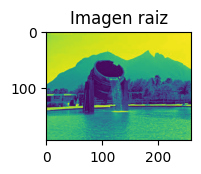

C:\Users\Dell\AppData\Local\Temp\ipykernel_13136\3329563801.py:31: RuntimeWarning: overflow encountered in scalar add
  region_mean = (region_mean + imagen[nx, ny]) // 2


In [60]:
mostrat_imagen_segmentada('monterrey.jpg')